# __Stock market risk analysis using Browninan Motion__

#### Aloken Chaudhari

#### Import dependencies

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Plot Apple's Stock over the course of a year 

Display how the graph changes when displaying Open price, Close price, High price, and Low Price for each day.
<br>
Also display volume of stocks traded per day

In [3]:
apple = yf.Ticker("AAPL")

today = datetime.now()

start_date = today - timedelta(days=365)

hist = apple.history(start = start_date, end = today)

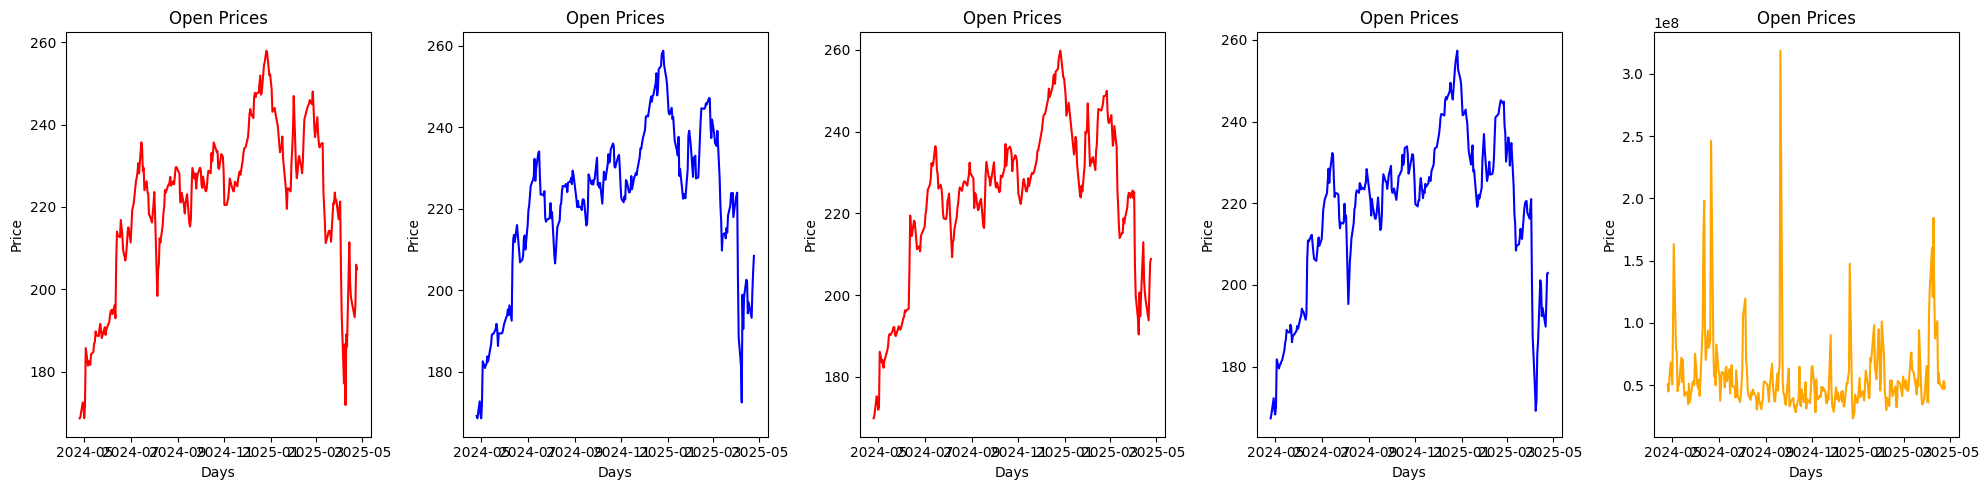

In [4]:
y1 = hist['Open']
y2 = hist['Close']
y3 = hist['High']
y4 = hist['Low']
y5 = hist['Volume']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].plot(y1, label='Open', color='red')
axes[0].set_title('Open Prices')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Price')

axes[1].plot(y2, label='Close', color='blue')
axes[1].set_title('Open Prices')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price')

axes[2].plot(y3, label='High', color='red')
axes[2].set_title('Open Prices')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Price')

axes[3].plot(y4, label='Low', color='blue')
axes[3].set_title('Open Prices')
axes[3].set_xlabel('Days')
axes[3].set_ylabel('Price')

axes[4].plot(y5, label='Volume', color='orange')
axes[4].set_title('Open Prices')
axes[4].set_xlabel('Days')
axes[4].set_ylabel('Price')

plt.tight_layout()
plt.show()


### Tarrif Implications on Stocks

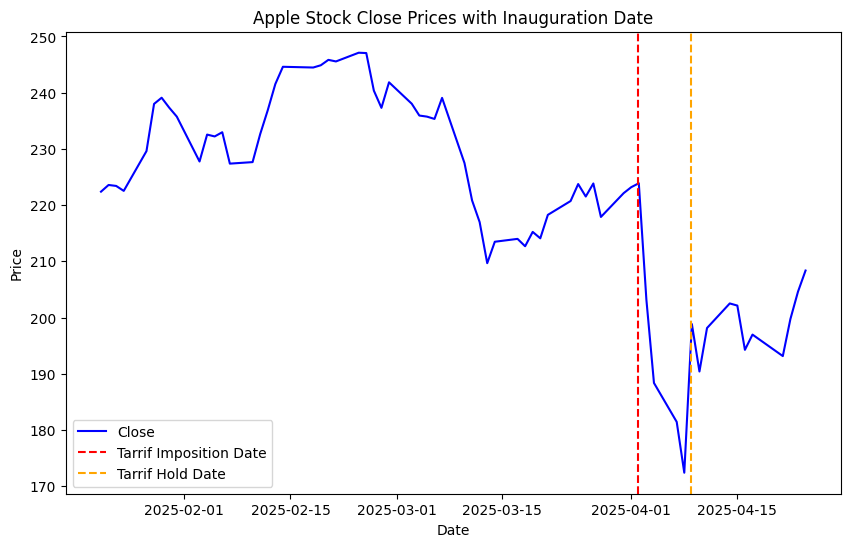

In [20]:
inauguration = '2025-01-20'

tarrif_imposition = datetime.strptime('2025-04-02', '%Y-%m-%d')

tarrif_hold = datetime.strptime('2025-04-09', '%Y-%m-%d')


hist_t = apple.history(start = inauguration, end = today)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(hist_t.index, hist_t['Close'], label='Close', color='blue')

ax.axvline(tarrif_imposition, color='red', linestyle='--', label='Tarrif Imposition Date')

ax.axvline(tarrif_hold, color='orange', linestyle='--', label='Tarrif Hold Date')


ax.set_title('Apple Stock Close Prices with Inauguration Date')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()
